In [30]:
%load_ext autoreload
%autoreload 2
import os
import pickle
import numpy as np
import cvxpy as cp
import dynamiqs as dq
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm.notebook import tqdm
from src.utilities import rho_reconstruction, rho_cat_state
from numpy.fft import fft2, ifft2, fftshift, ifftshift

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Task A

## A.1 Wigner function of fock state and cat state

We get familiar with Wigner functions by plotting the Wigner function of different quantum states with dynamiqs

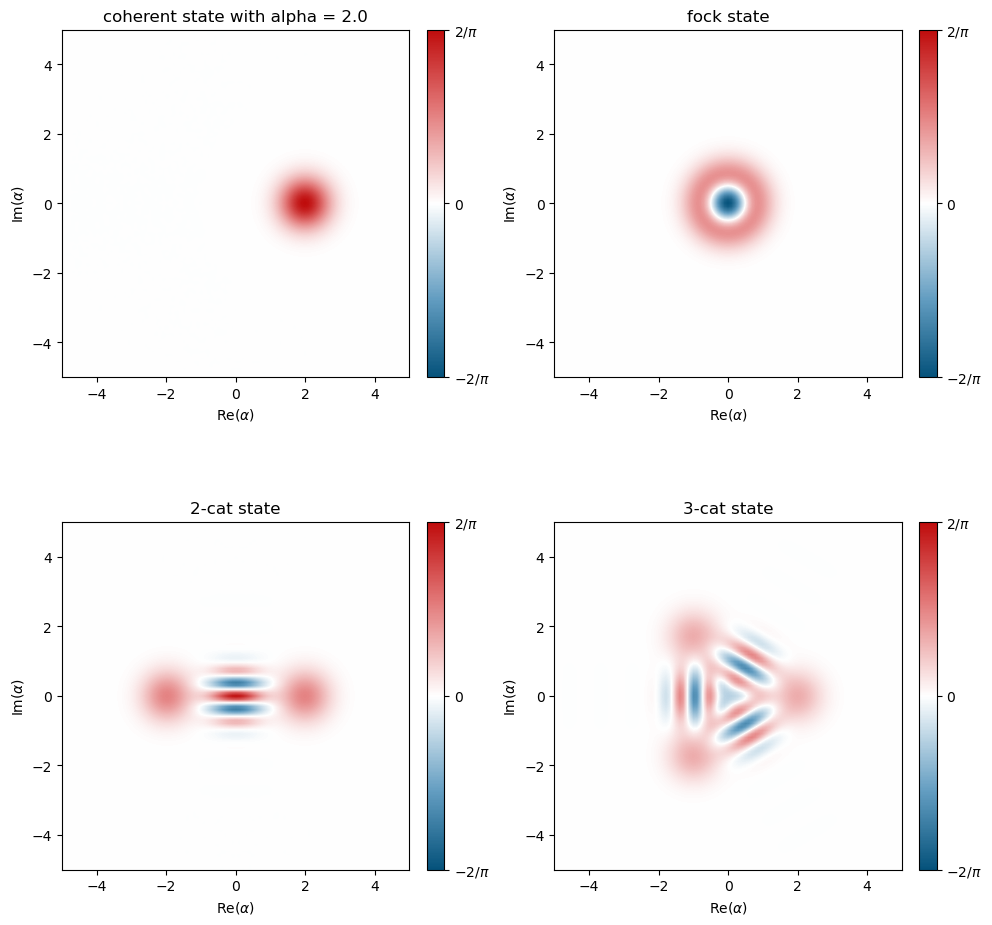

In [2]:
# parameters
n = 100      #dimension of Hilbert space (must be increased for numerical accuracy if the photon number of coherent state is increased)
alpha = 2.0  #coherent state amplitude
N =1

#define creation and anihilation operators
a = dq.destroy(n)
adag = dq.create(n)

#coherent state 
coherent_state = dq.coherent(n, alpha)

#fock state
n_state=dq.fock(n,N)

#cat 2 state
cat_state_2 = dq.unit(dq.coherent(n,alpha) + dq.coherent(n,-alpha))

# cat 3 state
cat_state_3 = dq.unit(
    dq.coherent(n, alpha) +
    dq.coherent(n, jnp.exp(1j * 2 * jnp.pi / 3) * alpha) +
    dq.coherent(n, jnp.exp(1j * 4 * jnp.pi / 3) * alpha)
)


# Plot the Wigner function of all the 4 states
fig, axs = plt.subplots(2, 2, figsize=(10, 10)) # Adjust figsize as needed

# Plot 1: Coherent State
dq.plot.wigner(coherent_state, ax=axs[0, 0],  colorbar=True)
axs[0, 0].set_title(f'coherent state with alpha = {alpha}')

# Plot 2: Fock State
dq.plot.wigner(n_state, ax=axs[0, 1], colorbar=True)
axs[0, 1].set_title('fock state')

# Plot 3: Cat 2 State
dq.plot.wigner(cat_state_2, ax=axs[1, 0], colorbar=True)
axs[1, 0].set_title('2-cat state')

# Plot 4: Cat 3 State
dq.plot.wigner(cat_state_3, ax=axs[1, 1], colorbar=True)
axs[1, 1].set_title('3-cat state')

# Adjust layout to prevent overlapping titles/plots
plt.tight_layout()

# Show the plots
plt.show()

## A.2. Evolution of a $|0 \rangle$ state in a 2 photon dissipative process

We observe how the vacuum state transforms into a 2-cat state under a 2 photondissipative process

|██████████| 100.0% ◆ elapsed 164.51ms ◆ remaining 0.00ms 
100%|██████████| 125/125 [00:04<00:00, 28.87it/s]


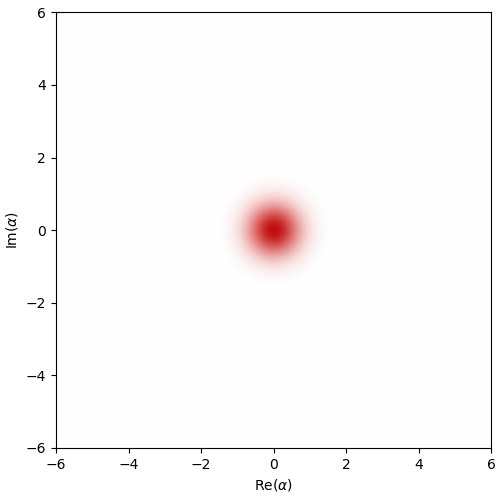

In [3]:
#parameters
na, nb = 10, 10 #dimension of the Hilbert spaces
g2 = 1.0 + 0.0j
eps_b = -4.0 + 0j
kappa_b = 10.0

# creation and anihilation operators
a = dq.tensor(dq.destroy(na), dq.eye(nb))  # a ⊗ I
adag = dq.tensor(dq.create(na), dq.eye(nb))
b = dq.tensor(dq.eye(na), dq.destroy(nb))  # I ⊗ b
bdag = dq.tensor(dq.eye(na), dq.create(nb))

# Dissipative Hamiltonian 
H = jnp.conj(g2) * (adag @ adag) @ b + g2 * (a @ a) @ bdag \
  + jnp.conj(eps_b) * b + eps_b * bdag

# collapse operators
collapse_ops = [jnp.sqrt(kappa_b) * b]

# Initial state 
psi0 = dq.tensor(dq.fock(na, 0), dq.fock(nb, 0))

# Run the master equation solver
tsave = jnp.linspace(0.0,4, 200) #time 
result = dq.mesolve(H, collapse_ops, psi0, tsave) #solve the master equation

#take the partial trace of mode a
reduced_result = [dq.ptrace(matrix, 0, (na,nb)) for matrix in result.states] 

#plot a GIF of the evolution of the state
dq.plot.wigner_gif(reduced_result,fps=25, xmax=6.0, ymax=6.0)

## Bonus part to task A: evaluate the effect of the dissipations $\kappa_a$, $\kappa_b$

W enow compute the 2 photon dissipation of a vacuum state BUT adding a dissipation on the resonator encoding the cat state.

We observe that the interference pattern decreases with time, indicating a loss of coherence of the state

|██████████| 100.0% ◆ elapsed 442.87ms ◆ remaining 0.00ms  
100%|██████████| 125/125 [00:04<00:00, 28.51it/s]


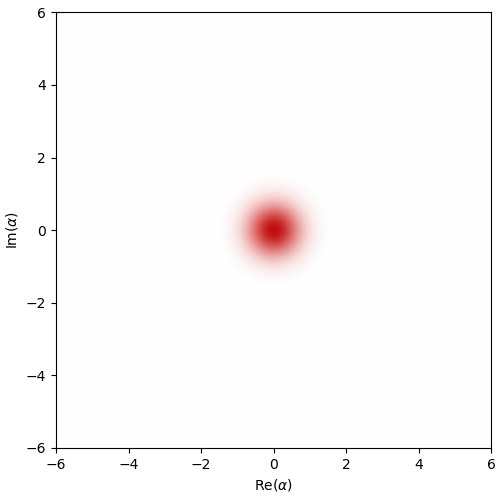

In [4]:
kappa_a = 0.1

# we add dissipation on the phhoton encoding the cat state
collapse_ops = [jnp.sqrt(kappa_b) * b] + [jnp.sqrt(kappa_a)*a ]   

# Run the master equation solver
tsave = jnp.linspace(0.0,8, 300) #time 
result = dq.mesolve(H, collapse_ops, psi0, tsave) #solve the master equation
reduced_result1 = [dq.ptrace(matrix, 0, (na,nb)) for matrix in result.states]

#plot a GIF of the evolution of the state
dq.plot.wigner_gif(reduced_result1,fps=25, xmax=6.0, ymax=6.0)

The value of $\kappa_b$ must be well chosen. We observe that if kappa_b is too great, we don't have the creation of the cat state due to the to great loss of photon by the buffer, and reciprocaaly if we put a too low value, the state oscillate and don't stabilize to a cat state.

|██████████| 100.0% ◆ elapsed 2.58s ◆ remaining 0.00ms  
100%|██████████| 125/125 [00:04<00:00, 30.18it/s]


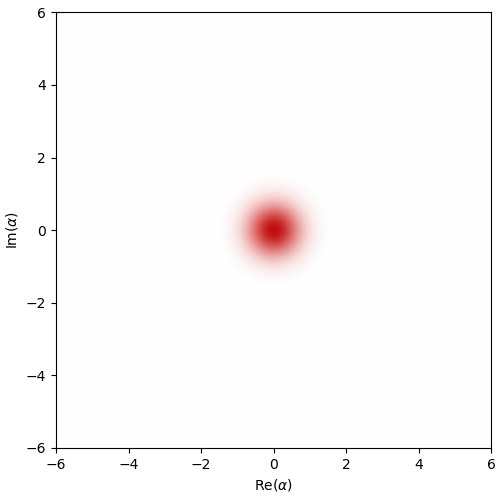

In [5]:
kappa_a = 0.1
kappa_b = 100 #too big

# we add dissipation on the phhoton encoding the cat state
collapse_ops = [jnp.sqrt(kappa_b) * b] + [jnp.sqrt(kappa_a)*a ]   

# Run the master equation solver
tsave = jnp.linspace(0.0,8, 300) #time 
result = dq.mesolve(H, collapse_ops, psi0, tsave) #solve the master equation
reduced_result1 = [dq.ptrace(matrix, 0, (na,nb)) for matrix in result.states]

#plot a GIF of the evolution of the state
dq.plot.wigner_gif(reduced_result1,fps=25, xmax=6.0, ymax=6.0)

|██████████| 100.0% ◆ elapsed 341.12ms ◆ remaining 0.00ms  
100%|██████████| 125/125 [00:04<00:00, 28.30it/s]


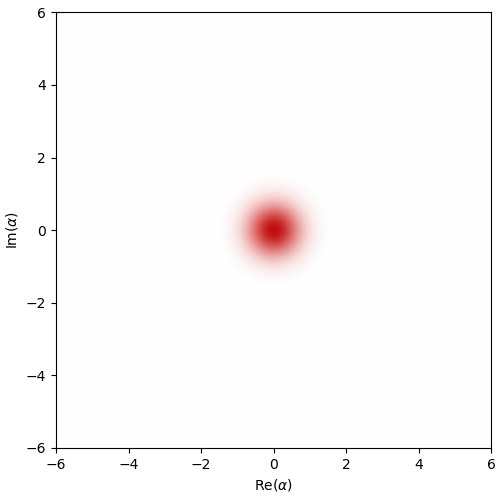

In [6]:
kappa_a = 0.1
kappa_b = 0.1 #too small

# we add dissipation on the phhoton encoding the cat state
collapse_ops = [jnp.sqrt(kappa_b) * b] + [jnp.sqrt(kappa_a)*a ]   

# Run the master equation solver
tsave = jnp.linspace(0.0,8, 300) #time 
result = dq.mesolve(H, collapse_ops, psi0, tsave) #solve the master equation
reduced_result1 = [dq.ptrace(matrix, 0, (na,nb)) for matrix in result.states]

#plot a GIF of the evolution of the state
dq.plot.wigner_gif(reduced_result1,fps=25, xmax=6.0, ymax=6.0)

# Task B

## B.1. Reconstruction of $\rho$ of ideal Wigner function

We reconstruct a density matrix from its Wigner function, basically by using an optimization process which tests different values of density matrices and finds which one gives the wished wigner function. This is a convex problem which has therefore only one minium toward which the optimization process converges

In [7]:
# Parameters
N = 30
N_fit = 100
xvec = np.linspace(-5, 5, 200)
pvec = np.linspace(-5, 5, 200)
grid = np.linspace(-3, 3, 11)
alpha_list = [x + 1j*y for x in grid for y in grid]

# Define test kets
test_states = {
    'fock_n3': dq.fock(N, 3),
    'coherent': dq.coherent(N, 1.2 + 0.5j),
    'cat2': dq.unit(dq.coherent(N, 1.2 + 0.5j) + dq.coherent(N, -1.2 - 0.5j)),
    'cat3': dq.unit(sum(
        dq.coherent(N, 1.2 + 0.5j * np.exp(1j * 2 * np.pi * k / 3))
        for k in range(3)))
}

rho_rec_dict = {}
metrics_dict = {}

# Run tomography + evaluation using wigner_fn
for name, psi in test_states.items():
    rho_true = psi @ psi.dag()
    _, _, W_jax = dq.wigner(psi, xvec=xvec, yvec=pvec)
    W_grid = np.asarray(W_jax)

    rho_rec, w_k, E_ops, metrics = rho_reconstruction(
        W_grid=W_grid,
        xvec=xvec,
        pvec=pvec,
        alpha_list=alpha_list,
        N_psi=N,
        N_fit=N_fit,
        rho_reference=rho_true
    )
    rho_rec_dict[name] = rho_rec
    metrics_dict[name] = metrics
    
    print(name)
    print(metrics)

/Users/joancaceres/Documents/ETH_Quantum_Hackhaton_2025/src/utilities.py:149: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  return 0.5 * (I_big + D @ P_big @ D.dag())
/Users/joancaceres/anaconda3/envs/ayb_env/lib/python3.13/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


fock_n3
  fidelity: 0.986639,
  trace_dist: 0.013727,
  HS_dist: 0.014660,
  purity_rec: 0.973494,
  eig_true: [1., 0., 0.],
  eig_rec: [0.9866, 0.0039, 0.0023]

coherent
  fidelity: 0.997472,
  trace_dist: 0.022965,
  HS_dist: 0.030621,
  purity_rec: 0.994123,
  eig_true: [1.0000e+00, 2.6913e-08, 5.9068e-09],
  eig_rec: [9.9706e-01, 2.5705e-04, 1.8382e-04]

cat2
  fidelity: 0.993245,
  trace_dist: 0.012415,
  HS_dist: 0.014094,
  purity_rec: 0.985922,
  eig_true: [1.0000e+00, 3.4297e-10, 2.4454e-16],
  eig_rec: [9.9293e-01, 3.3666e-03, 7.8248e-04]

cat3
  fidelity: 0.991917,
  trace_dist: 0.033847,
  HS_dist: 0.043317,
  purity_rec: 0.985034,
  eig_true: [1.0000e+00, 1.1341e-08, 1.6340e-09],
  eig_rec: [9.9248e-01, 3.9859e-03, 2.3984e-04]



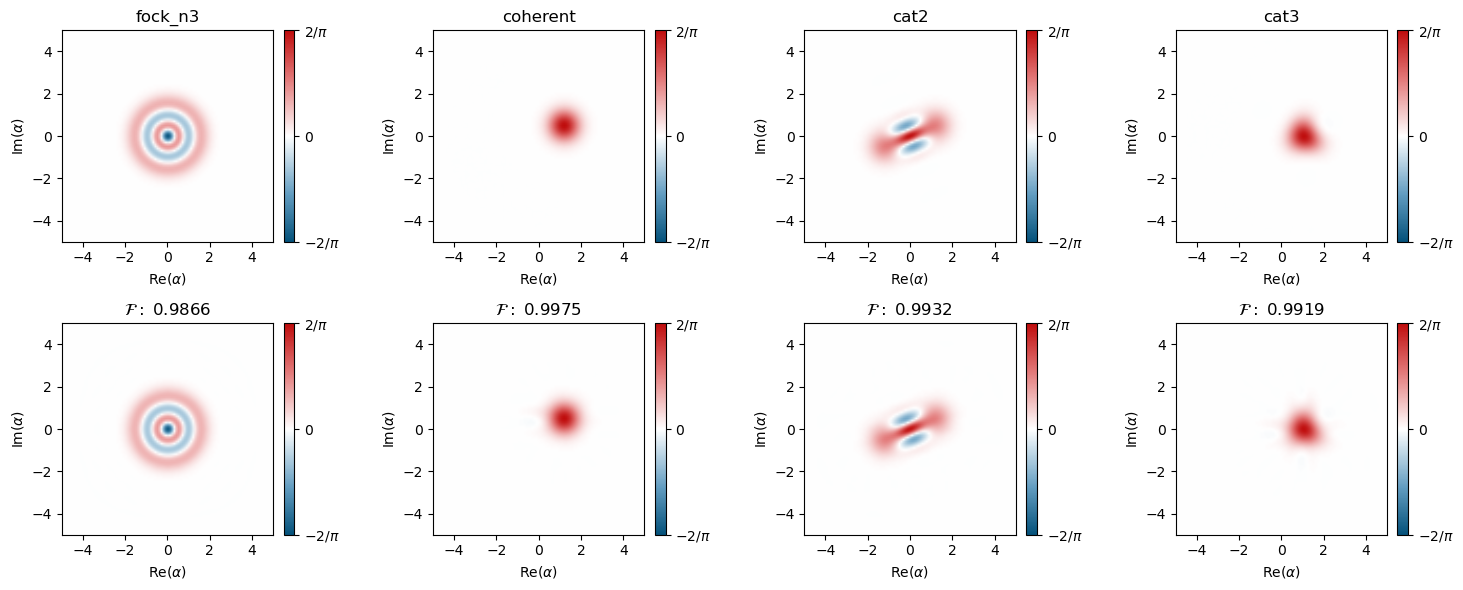

In [8]:
fig, ax = plt.subplots(2,4, figsize=(15, 6))
for i, (name, rho_rec) in enumerate(rho_rec_dict.items()):
    # Plot the Wigner function of the reconstructed state
    rho_original = test_states[name] @ test_states[name].dag()
    dq.plot.wigner(rho_original, ax=ax[0,i])
    dq.plot.wigner(rho_rec, ax=ax[1,i])
    ax[0,i].set_title(name)
    ax[1,i].set_title(rf'$\mathcal{{F}}:$ {metrics_dict[name].fidelity:.4f}')
fig.tight_layout()
plt.show()

## C.1. Reconstruction of $\rho$ with noisy Wigner function

We add gaussian noise with different standard deviation $\sigma$ and observe the effect on the fidelity of the reconstruction, as well as other metrics like the trace distance etc.

In [9]:
# Parameters
N = 30
N_fit = 100
xvec = np.linspace(-5, 5, 200)
pvec = np.linspace(-5, 5, 200)
grid = np.linspace(-3, 3, 11)
alpha_list = [x + 1j*y for x in grid for y in grid]

# States to test
test_states = {
    'fock_n3': dq.fock(N, 3),
    'coherent': dq.coherent(N, 1.2 + 0.5j),
    'cat2': dq.unit(dq.coherent(N, 1.2 + 0.5j) + dq.coherent(N, -1.2 - 0.5j)),
    'cat3': dq.unit(sum(
        dq.coherent(N, 1.2 + 0.5j * np.exp(1j * 2 * np.pi * k / 3))
        for k in range(3)))
}

# Dictionnary storing the different metrics
metrics_data = {
    'fock_n3': {'sigma': [], 'fidelity': [], 'trace_dist': [], 'HS_dist': [], 'purity_rec': []},
    'coherent': {'sigma': [], 'fidelity': [], 'trace_dist': [], 'HS_dist': [], 'purity_rec': []},
    'cat2': {'sigma': [], 'fidelity': [], 'trace_dist': [], 'HS_dist': [], 'purity_rec': []},
    'cat3': {'sigma': [], 'fidelity': [], 'trace_dist': [], 'HS_dist': [], 'purity_rec': []},   
}

# Sigma values (standard deviation of the gaussian noise)
sigma_values = np.linspace(0.0, 0.08, 20)

for sigma in tqdm(sigma_values):
    for name, psi in test_states.items():
        rho_true = psi @ psi.dag()
        
        # Calculate ideal Wigner
        _, _, W_jax = dq.wigner(psi, xvec=xvec, yvec=pvec)
        W_grid = np.asarray(W_jax)
        
        # Add gaussian noise
        noisy_W = W_grid + np.random.normal(loc=0.0, scale=sigma, size=W_grid.shape)

        # Reconstruct density matrix from noisy Wigner
        rho_rec, w_k, E_ops, metrics = rho_reconstruction(
            W_grid= noisy_W,
            xvec=xvec,
            pvec=pvec,
            alpha_list=alpha_list,
            N_psi=N,
            N_fit=N_fit,
            rho_reference=rho_true
        )

        # Save different metrics
        metrics_data[name]['sigma'].append(sigma)
        metrics_data[name]['fidelity'].append(metrics.fidelity)
        metrics_data[name]['trace_dist'].append(metrics.trace_dist)
        metrics_data[name]['HS_dist'].append(metrics.HS_dist)
        metrics_data[name]['purity_rec'].append(metrics.purity_rec)

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/joancaceres/Documents/ETH_Quantum_Hackhaton_2025/src/utilities.py:149: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  return 0.5 * (I_big + D @ P_big @ D.dag())
/Users/joancaceres/anaconda3/envs/ayb_env/lib/python3.13/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


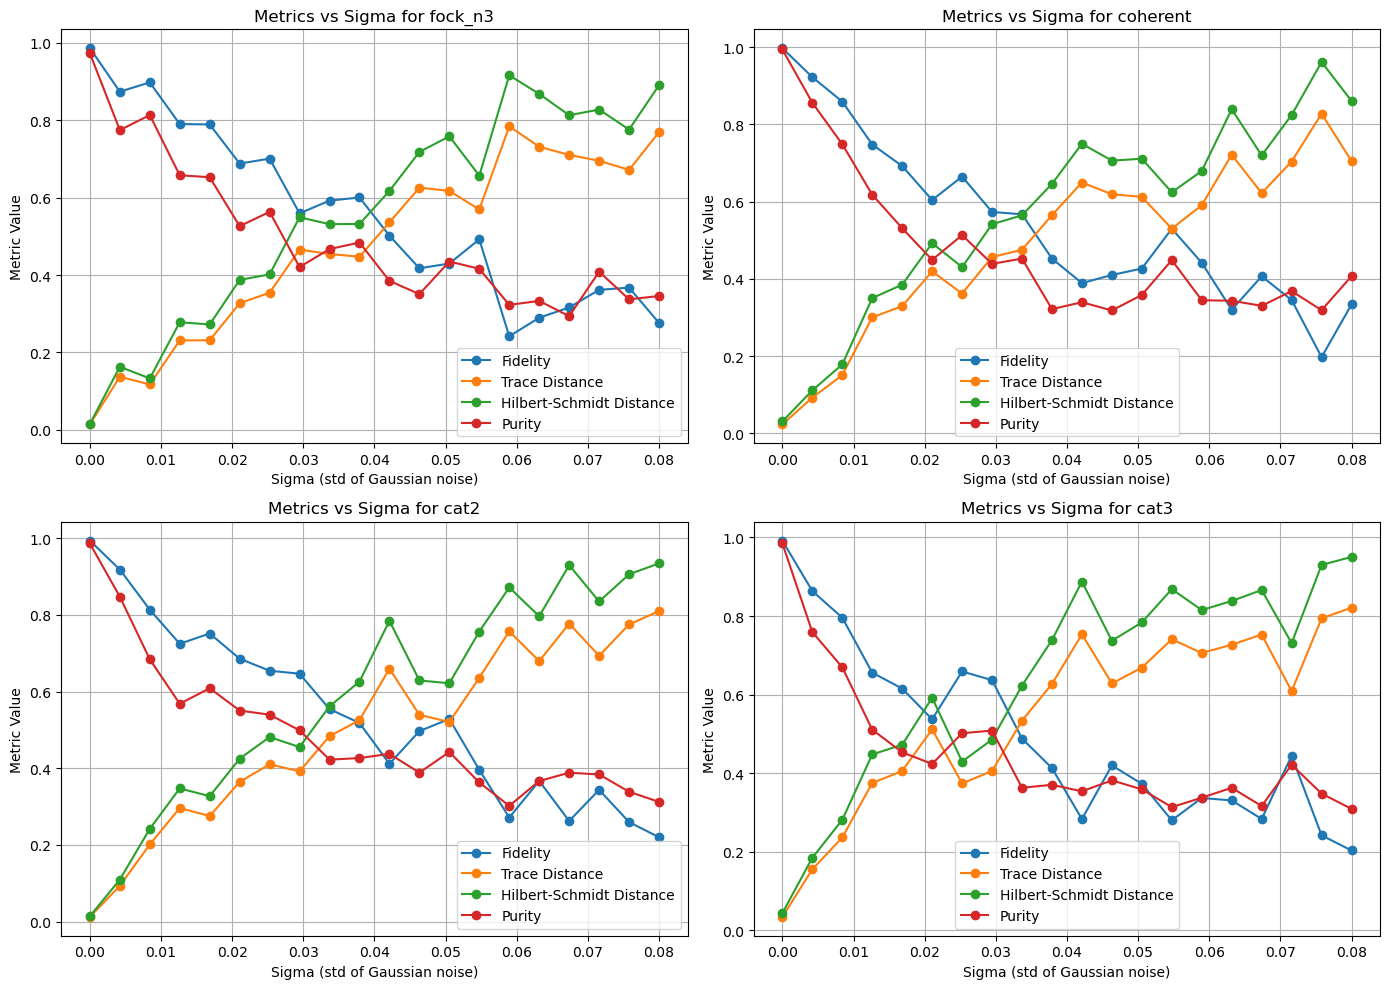

In [10]:
# Determine number of subplots needed
num_plots = len(metrics_data)
ncols = 2
nrows = int(np.ceil(num_plots / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 5 * nrows), squeeze=False)

# Flatten axes for easy indexing
axes = axes.flatten()

for idx, (name, data) in enumerate(metrics_data.items()):
    ax = axes[idx]
    ax.plot(data['sigma'], data['fidelity'], label='Fidelity', marker='o')
    ax.plot(data['sigma'], data['trace_dist'], label='Trace Distance', marker='o')
    ax.plot(data['sigma'], data['HS_dist'], label='Hilbert-Schmidt Distance', marker='o')
    ax.plot(data['sigma'], data['purity_rec'], label='Purity', marker='o')
    ax.set_title(f"Metrics vs Sigma for {name}")
    ax.set_xlabel("Sigma (std of Gaussian noise)")
    ax.set_ylabel("Metric Value")
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

# C. Real data

In [11]:
# Directory containing the pickle files
data_dir = 'data/experimental/'

# Dictionary to store the loaded data
loaded_data = {}

# Iterate over all files in the directory
for file_name in os.listdir(data_dir):
    if file_name.endswith('.pickle'):
        file_path = os.path.join(data_dir, file_name)
        with open(file_path, 'rb') as file:
            try:
                xvec, pvec, W_grid = pickle.load(file)
                loaded_data[file_name.replace('.pickle', '')] = {
                    'xvec': xvec,
                    'pvec': pvec,
                    'Wigner': W_grid
                }
            except Exception as e:
                print(f"Error loading {file_name}: {e}")

# Verify the loaded files
print(f"Loaded files: {list(loaded_data.keys())}")

Loaded files: ['wigner_cat_plus', 'wigner_cat_minus', 'wigner_fock_zero', 'wigner_fock_one', 'wigner_cat_plus_25', 'wigner_cat_plus_113', 'wigner_cat_plus_56']


In [12]:
N = 30

# Fock zero state
psi = dq.fock(N, 0)
rho_fock_zero = psi @ psi.dag()

# Fock one state
psi = dq.fock(N, 1)
rho_fock_one = psi @ psi.dag()

# Cat plus state
rho_cat_plus = rho_cat_state(N=N, alpha=np.sqrt(2.5), sign='+')

# Cat minus state
rho_cat_minus = rho_cat_state(N=N, alpha=np.sqrt(2.5), sign='-')

# Cat plus 5.6 state
rho_cat_plus_56 = rho_cat_state(N=N, alpha=np.sqrt(5.6), sign='+')

# Cat plus 11.3 state
rho_cat_plus_113 = rho_cat_state(N=N, alpha=np.sqrt(11.3), sign='+')

rho_target_dict = {
    'fock_0': rho_fock_zero,
    'fock_1': rho_fock_one,
    'cat_plus': rho_cat_plus,
    'cat_minus': rho_cat_minus,
    'cat_plus_56': rho_cat_plus_56,
    'cat_plus_113': rho_cat_plus_113
}

### B.2.1. Fock zero

In [13]:
# Parameters
N_fit = 200

xvec = loaded_data['wigner_fock_zero']['xvec']
pvec = loaded_data['wigner_fock_zero']['pvec']
W_grid = loaded_data['wigner_fock_zero']['Wigner']

grid_number = 20
xgrid = np.linspace(xvec.min(), xvec.max(), grid_number)
pgrid = np.linspace(pvec.min(), pvec.max(), grid_number)
alpha_list = [x + 1j*y for x in xgrid for y in pgrid]

rho_rec_fock_zero, w_k, E_ops, fock_zero_metrics = rho_reconstruction(
    W_grid=W_grid,
    xvec=xvec,
    pvec=pvec,
    alpha_list=alpha_list,
    N_psi=N,
    N_fit=N_fit,
    rho_reference=rho_target_dict['fock_0']
)

fock_zero_metrics

  fidelity: 0.867891,
  trace_dist: 0.138234,
  HS_dist: 0.187505,
  purity_rec: 0.770941,
  eig_true: [1., 0., 0.],
  eig_rec: [0.869 , 0.1255, 0.0055]

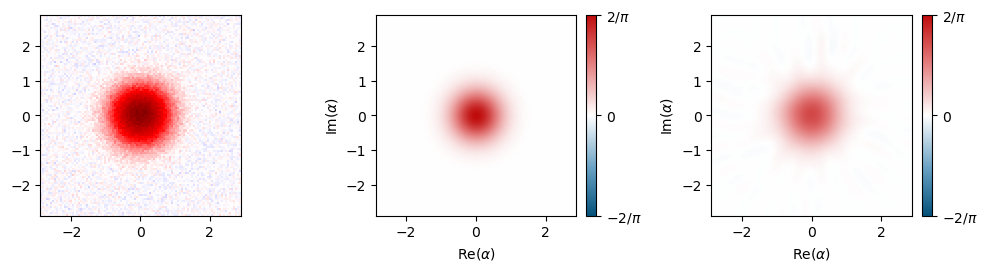

In [14]:
vmin = -max(abs(W_grid.min()), abs(W_grid.max()))
vmax = max(abs(W_grid.min()), abs(W_grid.max()))

fig, ax = plt.subplots(1,3, figsize=(10, 5))
X,P = np.meshgrid(xvec, pvec)
ax[0].set_aspect('equal')
ax[0].pcolormesh(X,P, W_grid.T,cmap='seismic', vmin=vmin, vmax=vmax, shading='auto')
dq.plot.wigner(rho_target_dict['fock_0'], ax= ax[1], xmax = max(xvec), ymax = max(pvec))
dq.plot.wigner(rho_rec_fock_zero, ax= ax[2], xmax = max(xvec), ymax = max(pvec))
fig.tight_layout()

### B.2.2. Fock one

In [15]:
# Parameters
N = 30
N_fit = 200

xvec = loaded_data['wigner_fock_one']['xvec']
pvec = loaded_data['wigner_fock_one']['pvec']
W_grid = loaded_data['wigner_fock_one']['Wigner']

grid_number = 20
xgrid = np.linspace(xvec.min(), xvec.max(), grid_number)
pgrid = np.linspace(pvec.min(), pvec.max(), grid_number)

alpha_list = [x + 1j*y for x in xgrid for y in pgrid]

rho_rec_fock_1, w_k, E_ops, metrics_fock_1 = rho_reconstruction(
    W_grid=W_grid,
    xvec=xvec,
    pvec=pvec,
    alpha_list=alpha_list,
    N_psi=N,
    N_fit=N_fit,
    rho_reference=rho_target_dict['fock_1']
)

metrics_fock_1


/Users/joancaceres/Documents/ETH_Quantum_Hackhaton_2025/src/utilities.py:149: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  return 0.5 * (I_big + D @ P_big @ D.dag())


  fidelity: 0.518733,
  trace_dist: 0.482641,
  HS_dist: 0.633111,
  purity_rec: 0.438297,
  eig_true: [1., 0., 0.],
  eig_rec: [0.5199, 0.408 , 0.0324]

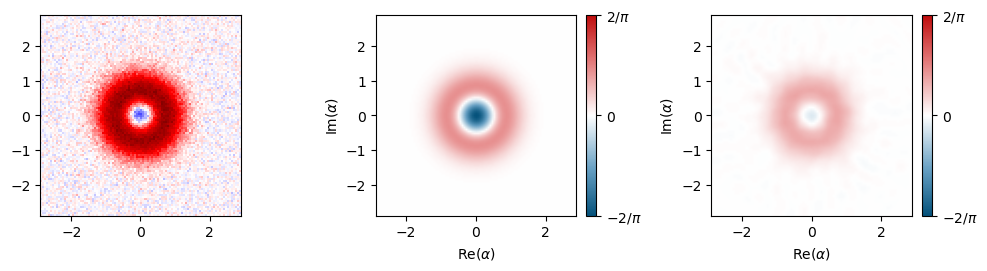

In [16]:
vmin = -max(abs(W_grid.min()), abs(W_grid.max()))
vmax = max(abs(W_grid.min()), abs(W_grid.max()))

fig, ax = plt.subplots(1,3, figsize=(10, 5))
X,P = np.meshgrid(xvec, pvec)
ax[0].pcolormesh(X,P, W_grid.T,cmap='seismic', vmin=vmin, vmax=vmax)
ax[0].set_aspect('equal')
dq.plot.wigner(rho_target_dict['fock_1'], ax= ax[1], xmax = max(xvec), ymax = max(pvec))
dq.plot.wigner(rho_rec_fock_1, ax= ax[2], xmax = max(xvec), ymax = max(pvec))
fig.tight_layout()

### B.2.3. Cat plus

In [17]:
# Parameters
N_fit = 200

xvec = loaded_data['wigner_cat_plus']['xvec']
pvec = loaded_data['wigner_cat_plus']['pvec']
W_grid = loaded_data['wigner_cat_plus']['Wigner']

grid_number = 20
xgrid = np.linspace(xvec.min(), xvec.max(), grid_number)
pgrid = np.linspace(pvec.min(), pvec.max(), grid_number)

alpha_list = [x + 1j*y for x in xgrid for y in pgrid]

rho_rec_cat_plus, w_k, E_ops, metrics_cat_plus = rho_reconstruction(
    W_grid=W_grid,
    xvec=xvec,
    pvec=pvec,
    alpha_list=alpha_list,
    N_psi=N,
    N_fit=N_fit,
    rho_reference=rho_target_dict['cat_plus'],
    max_iters=1000,
)

metrics_cat_plus

/Users/joancaceres/Documents/ETH_Quantum_Hackhaton_2025/src/utilities.py:149: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  return 0.5 * (I_big + D @ P_big @ D.dag())


  fidelity: 0.678828,
  trace_dist: 0.352538,
  HS_dist: 0.459748,
  purity_rec: 0.568111,
  eig_true: [1.0000e+00, 6.3894e-09, 2.8452e-10],
  eig_rec: [0.6954, 0.2904, 0.0142]

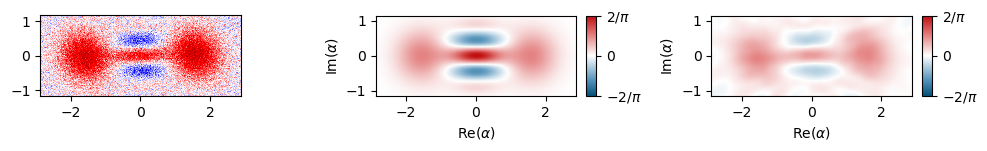

In [18]:
vmin = -max(abs(W_grid.min()), abs(W_grid.max()))
vmax = max(abs(W_grid.min()), abs(W_grid.max()))

fig, ax = plt.subplots(1,3, figsize=(10, 5))
X,P = np.meshgrid(xvec, pvec)
ax[0].pcolormesh(X,P, W_grid.T,cmap='seismic', vmin=vmin, vmax=vmax)
ax[0].set_aspect('equal')
dq.plot.wigner(rho_target_dict['cat_plus'], ax= ax[1], xmax = max(xvec), ymax = max(pvec))
dq.plot.wigner(rho_rec_cat_plus, ax= ax[2], xmax = max(xvec), ymax = max(pvec))
fig.tight_layout()

### B.2.4. Cat minus

In [19]:
# Parameters
N = 30
N_fit = 200

xvec = loaded_data['wigner_cat_minus']['xvec']
pvec = loaded_data['wigner_cat_minus']['pvec']
W_grid = loaded_data['wigner_cat_minus']['Wigner']

grid_number = 20
xgrid = np.linspace(xvec.min(), xvec.max(), grid_number)
pgrid = np.linspace(pvec.min(), pvec.max(), grid_number)

alpha_list = [x + 1j*y for x in xgrid for y in pgrid]

rho_rec_cat_minus, w_k, E_ops, metrics_cat_minus = rho_reconstruction(
    W_grid=W_grid,
    xvec=xvec,
    pvec=pvec,
    alpha_list=alpha_list,
    N_psi=N,
    N_fit=N_fit,
    rho_reference=rho_target_dict['cat_minus'],
    max_iters=1000,
)

metrics_cat_minus

/Users/joancaceres/Documents/ETH_Quantum_Hackhaton_2025/src/utilities.py:149: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  return 0.5 * (I_big + D @ P_big @ D.dag())


  fidelity: 0.609297,
  trace_dist: 0.422543,
  HS_dist: 0.561115,
  purity_rec: 0.532542,
  eig_true: [1.0000e+00, 3.7471e-09, 1.7652e-11],
  eig_rec: [0.6433, 0.3442, 0.0124]

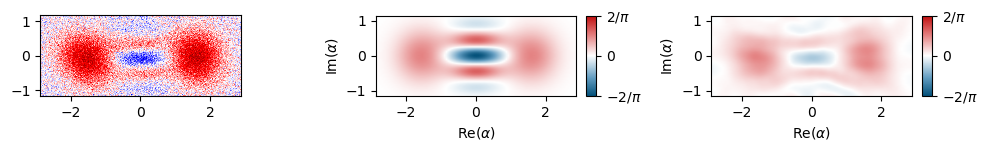

In [20]:
vmin = -max(abs(W_grid.min()), abs(W_grid.max()))
vmax = max(abs(W_grid.min()), abs(W_grid.max()))

fig, ax = plt.subplots(1,3, figsize=(10, 5))
X,P = np.meshgrid(xvec, pvec)
ax[0].pcolormesh(X,P, W_grid.T,cmap='seismic', vmin=vmin, vmax=vmax)
ax[0].set_aspect('equal')
dq.plot.wigner(rho_target_dict['cat_minus'], ax= ax[1], xmax = max(xvec), ymax = max(pvec))
dq.plot.wigner(rho_rec_cat_minus, ax= ax[2], xmax = max(xvec), ymax = max(pvec))
fig.tight_layout()

### B.2.4. Cat plus 56

In [21]:
# Parameters
N = 30
N_fit = 200
    
xvec = loaded_data['wigner_cat_plus_56']['xvec']
pvec = loaded_data['wigner_cat_plus_56']['pvec']
W_grid = loaded_data['wigner_cat_plus_56']['Wigner']

grid_number = 20
xgrid = np.linspace(xvec.min(), xvec.max(), grid_number)
pgrid = np.linspace(pvec.min(), pvec.max(), grid_number)

alpha_list = [x + 1j*y for x in xgrid for y in pgrid]

rho_rec_cat_plus_56, w_k, E_ops, metrics_cat_plus_56 = rho_reconstruction(
    W_grid=W_grid,
    xvec=xvec,
    pvec=pvec,
    alpha_list=alpha_list,
    N_psi=N,
    N_fit=N_fit,
    rho_reference=rho_target_dict['cat_plus_56'],
    max_iters=1000,
)

metrics_cat_plus_56

/Users/joancaceres/Documents/ETH_Quantum_Hackhaton_2025/src/utilities.py:149: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  return 0.5 * (I_big + D @ P_big @ D.dag())


  fidelity: 0.525142,
  trace_dist: 0.556112,
  HS_dist: 0.695544,
  purity_rec: 0.533225,
  eig_true: [1.0000e+00, 1.1618e-08, 2.0325e-09],
  eig_rec: [6.2888e-01, 3.7112e-01, 3.2940e-06]

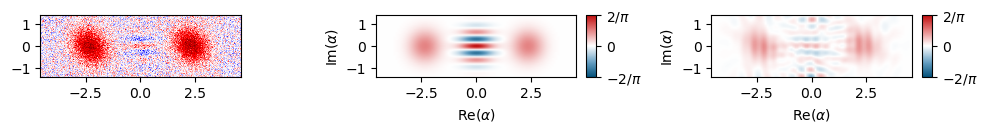

In [22]:
vmin = -max(abs(W_grid.min()), abs(W_grid.max()))
vmax = max(abs(W_grid.min()), abs(W_grid.max()))

fig, ax = plt.subplots(1,3, figsize=(10, 5))
X,P = np.meshgrid(xvec, pvec)
ax[0].pcolormesh(X,P, W_grid.T,cmap='seismic', vmin=vmin, vmax=vmax)
ax[0].set_aspect('equal')
dq.plot.wigner(rho_target_dict['cat_plus_56'], ax= ax[1], xmax = max(xvec), ymax = max(pvec))
dq.plot.wigner(rho_rec_cat_plus_56, ax= ax[2], xmax = max(xvec), ymax = max(pvec))
fig.tight_layout()

In [23]:
# Parameters
N = 30
N_fit = 200

    
xvec = loaded_data['wigner_cat_plus_113']['xvec']
pvec = loaded_data['wigner_cat_plus_113']['pvec']
W_grid = loaded_data['wigner_cat_plus_113']['Wigner']

grid_number = 20
xgrid = np.linspace(xvec.min(), xvec.max(), grid_number)
pgrid = np.linspace(pvec.min(), pvec.max(), grid_number)

alpha_list = [x + 1j*y for x in xgrid for y in pgrid]

rho_rec_cat_plus_113, w_k, E_ops, metrics_cat_plus_113 = rho_reconstruction(
    W_grid=W_grid,
    xvec=xvec,
    pvec=pvec,
    alpha_list=alpha_list,
    N_psi=N,
    N_fit=N_fit,
    rho_reference=rho_target_dict['cat_plus_113'],
    max_iters=1000,
)

metrics_cat_plus_113

/Users/joancaceres/Documents/ETH_Quantum_Hackhaton_2025/src/utilities.py:149: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  return 0.5 * (I_big + D @ P_big @ D.dag())


  fidelity: 0.487573,
  trace_dist: 0.540314,
  HS_dist: 0.725572,
  purity_rec: 0.500839,
  eig_true: [1.0000e+00, 6.3582e-09, 6.3582e-09],
  eig_rec: [5.2009e-01, 4.7994e-01, 1.6139e-05]

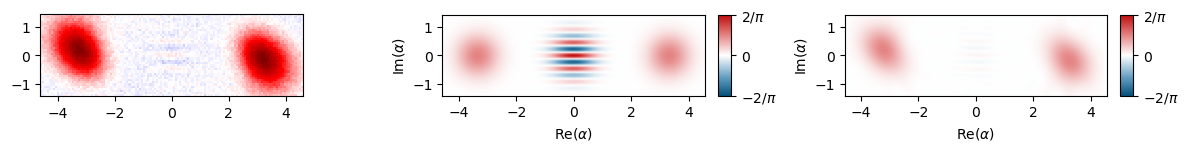

In [24]:
vmin = -max(abs(W_grid.min()), abs(W_grid.max()))
vmax = max(abs(W_grid.min()), abs(W_grid.max()))

fig, ax = plt.subplots(1,3, figsize=(12, 6))
X,P = np.meshgrid(xvec, pvec)
ax[0].pcolormesh(X,P, W_grid.T,cmap='seismic', vmin=vmin, vmax=vmax)
ax[0].set_aspect('equal')
dq.plot.wigner(rho_target_dict['cat_plus_113'], ax= ax[1], xmax = max(xvec), ymax = max(pvec))
dq.plot.wigner(rho_rec_cat_plus_113, ax= ax[2], xmax = max(xvec), ymax = max(pvec))
fig.tight_layout()

# Bonus section :

we wanted to know if our model could be interessant to simulate dissipation in the resonator, and obtain information on the purity and the coherence of the state in function of time, to know how long we could use our cat qubit.

So we used the hamiltonian created in the first section to simulate this dissipation, and we use our new fit system to obtain information on the state.

|██████████| 100.0% ◆ elapsed 500.39ms ◆ remaining 0.00ms  
100%|██████████| 125/125 [00:04<00:00, 27.87it/s]


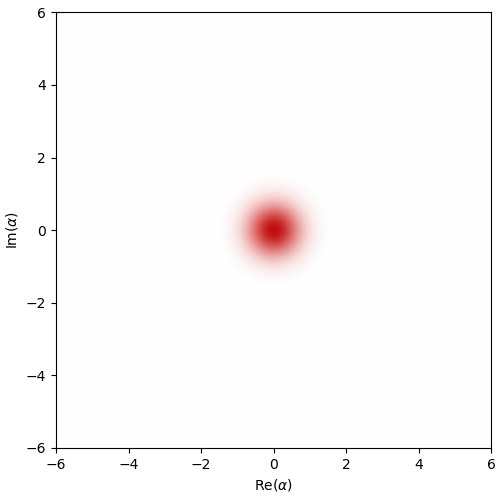

In [26]:
na, nb = 10,10 #dimension of the Hilbert spaces
g2 = 1.0 + 0.0j
eps_b = -4.0 + 0j
kappa_b = 10
kappa_a = 0.1


# creation and anihilation operators
a = dq.tensor(dq.destroy(na), dq.eye(nb))  # a ⊗ I
adag = dq.tensor(dq.create(na), dq.eye(nb))
b = dq.tensor(dq.eye(na), dq.destroy(nb))  # I ⊗ b
bdag = dq.tensor(dq.eye(na), dq.create(nb))

# Dissipative Hamiltonian 
H = jnp.conj(g2) * (adag @ adag) @ b + g2 * (a @ a) @ bdag \
  + jnp.conj(eps_b) * b + eps_b * bdag

# collapse operators
collapse_ops = [jnp.sqrt(kappa_b) * b] + [jnp.sqrt(kappa_a)*a ]  # dissipation with two photon loss and loss in resonator 

# Initial state 
psi0 = dq.tensor(dq.fock(na, 0), dq.fock(nb, 0))

# Run the master equation solver
tsave = jnp.linspace(0.0,8, 300) #time 
result = dq.mesolve(H, collapse_ops, psi0, tsave) #solve the master equation
reduced_result1 = [dq.ptrace(matrix, 0, (na,nb)) for matrix in result.states]
  
#plot a GIF of the evolution of the state
dq.plot.wigner_gif(reduced_result1,fps=25, xmax=6.0, ymax=6.0)

In [27]:
N = 10
N_fit = 225

t=100

rho_cat_plus = rho_cat_state(N=N, alpha=np.sqrt(2.5), sign='+')  #reference perfect state 

xvec,pvec,W_grid=dq.wigner(reduced_result1[t])
xvec= np.array(xvec)
yvec= np.array(pvec)
W_grid= np.array(W_grid)
print(type(xvec))

grid_number = 20
xgrid = np.linspace(xvec.min(), xvec.max(), grid_number)
pgrid = np.linspace(pvec.min(), pvec.max(), grid_number)

alpha_list = [x + 1j*y for x in xgrid for y in pgrid]

rho_rec_cat_plus_56, w_k, E_ops, metrics_cat = rho_reconstruction(
    W_grid=W_grid,
    xvec=xvec,
    pvec=pvec,
    alpha_list=alpha_list,
    N_psi=N,
    N_fit=N_fit,
    rho_reference=rho_cat_plus,
    max_iters=1000,
)

metrics_cat

<class 'numpy.ndarray'>


/Users/joancaceres/Documents/ETH_Quantum_Hackhaton_2025/src/utilities.py:149: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  return 0.5 * (I_big + D @ P_big @ D.dag())


  fidelity: 0.461938,
  trace_dist: 0.594173,
  HS_dist: 0.723239,
  purity_rec: 0.446823,
  eig_true: [1.0000e+00, 1.5218e-08, 3.0062e-09],
  eig_rec: [0.551 , 0.3765, 0.0299]

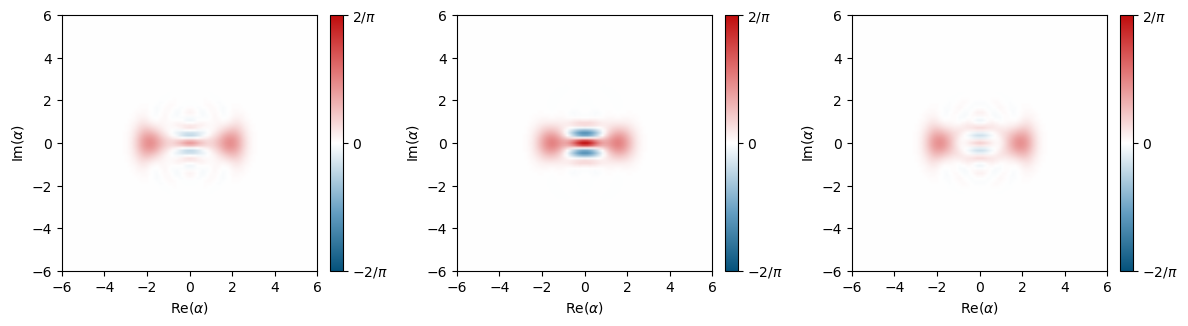

In [28]:
vmin = -max(abs(W_grid.min()), abs(W_grid.max()))
vmax = max(abs(W_grid.min()), abs(W_grid.max()))

fig, ax = plt.subplots(1,3, figsize=(12, 6))

dq.plot.wigner(reduced_result1[t],ax= ax[0], xmax = max(xvec), ymax = max(pvec))

dq.plot.wigner(rho_cat_plus , ax= ax[1], xmax = max(xvec), ymax = max(pvec))
dq.plot.wigner(rho_rec_cat_plus_56, ax= ax[2], xmax = max(xvec), ymax = max(pvec))

fig.tight_layout()

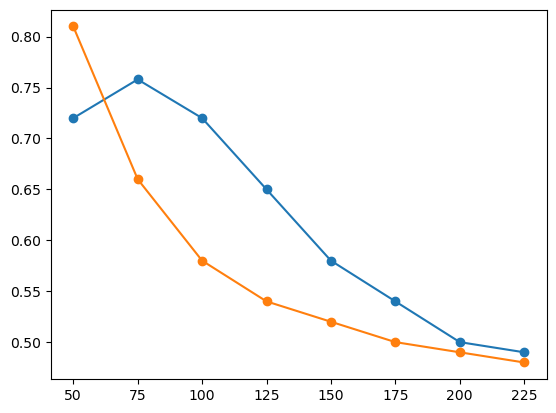

In [29]:
time=np.array([50,75,100,125,150,175,200,225])
fidelity=np.array([0.72,0.758,0.72,0.65,0.58,0.54,0.5,0.49])
purity=np.array([0.81,0.66,0.58,0.54,0.52,0.5,0.49,0.48])

plt.scatter(time,fidelity)
plt.plot(time,fidelity)
plt.scatter(time,purity)
plt.plot(time,purity)